# Artistic vs. Arabic MNIST 


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Introduction to challenge
We have decided to take a dataset from Kaggle ([Arabic Handwritten Characters Dataset](https://www.kaggle.com/mloey1/ahcd1)) for this challenge.   

- 16,800 characters written by 60 participants
- Each participant wrote each character (from ’alef’ to ’yeh’) ten times on two forms 
- The forms were scanned at the resolution of 300 dpi. Each block is segmented automatically using Matlab 2016a to determining the coordinates for each block. 
- The database is partitioned into two sets: a training set (13,440 characters to 480 images per class) and a test set (3,360 characters to 120 images per class).
- Writers of training set and test set are exclusive. Ordering of including writers to test set are randomized to make sure that writers of test set are not from a single institution (to ensure variability of the test set).

__Acknowledgements__:

- A. El-Sawy, M. Loey, and H. EL-Bakry, “Arabic handwritten characters recognition using convolutional neural network,” WSEAS Transactions on Computer Research, vol. 5, pp. 11–19, 2017. 
https://doi.org/10.1007/978-3-319-48308-5_54
https://link.springer.com/chapter/10.1007/978-3-319-48308-5_54

- A. El-Sawy, H. EL-Bakry, and M. Loey, “CNN for handwritten arabic digits recognition based on lenet-5,” in Proceedings of the International Conference on Advanced Intelligent Systems and Informatics 2016, vol. 533, pp. 566–575, Springer International Publishing, 2016.
https://www.wseas.org/multimedia/journals/computerresearch/2017/a045818-075.php

- Loey, Mohamed, Ahmed El-Sawy, and Hazem El-Bakry. "Deep learning autoencoder approach for handwritten arabic digits recognition." arXiv preprint arXiv:1706.06720 (2017).
https://arxiv.org/abs/1706.06720

## Data Import
Uncomment and adapt path. 

In [11]:
def get_kaggle_dataset():
  from google.colab import files
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
  # Then move kaggle.json into the folder where the API expects to find it.
  !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
  !kaggle datasets download -d 'mloey1/ahcd1'
  !mv ./*.zip /content/drive/MyDrive/DeepLearningInVisionHSLU/
  !unzip -q /content/drive/MyDrive/DeepLearningInVisionHSLU/*.zip -d /content/drive/MyDrive/DeepLearningInVisionHSLU/
  !rm /content/drive/MyDrive/DeepLearningInVisionHSLU/*.zip

## Imports

In [12]:
# Built-in imports
import os, datetime, pathlib, random, time
from glob import glob
import math
from math import ceil, floor

# Basic imports
import numpy as np
import pandas as pd   

# Ploting libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False
%matplotlib inline


import seaborn as sns
sns.set(color_codes=True)

import PIL
from PIL import Image
import skimage
from skimage import color, io
#from skimage import data
from skimage import transform

# Tensorflow imports
import tensorflow as tf
print(f'Tensorflow version is: {tf.version.VERSION}')
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image as kp_image
from tensorflow.keras.callbacks import TensorBoard 
from tensorflow.keras import applications, optimizers, models, losses, layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
#from tensorflow.keras.metrics import 

# Train-test-split and evaluation imports
from sklearn.model_selection import train_test_split # If required
from sklearn import metrics # classification report
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold

Tensorflow version is: 2.7.0
Found GPU at: /device:GPU:0


## Definitions

In [13]:
# Divides the input array into chunks of letters
def row_calculator(number_of_images, number_of_columns):
    if number_of_images % number_of_columns != 0:
        return (number_of_images / number_of_columns)+1
    else:
        return (number_of_images / number_of_columns)

# Display images by size and number of plots
def display_image(x, img_size, number_of_images):
    # Standard plot size
    plt.figure(figsize = (16, 9))
    # Takes only images 
    if x.shape[0] > 0:
        n_samples = x.shape[0]
        x = x.reshape(n_samples, img_size, img_size)
        number_of_rows = row_calculator(number_of_images, 4)
        for i in range(number_of_images):
            plt.subplot(number_of_rows, 4, i+1)
            plt.imshow(x[i])

# Show image by number
def show_image_by_num(img_num,array):
  img_num = img_num
  plt.imshow(test_data[img_num][:,:,0])
  plt.axis('off')

def valid_imshow_data(data):
    data = np.asarray(data)
    if data.ndim == 2:
        return True
    elif data.ndim == 3:
        if 3 <= data.shape[2] <= 4:
            return True
        else:
            print('The "data" has 3 dimensions but the last dimension '
                  'must have a length of 3 (RGB) or 4 (RGBA), not "{}".'
                  ''.format(data.shape[2]))
            return False
    else:
        print('To visualize an image the data must be 2 dimensional or '
              '3 dimensional, not "{}".'
              ''.format(data.ndim))
        return False

# Show content of dictionary
def get_dir_content(path):
  return os.listdir(path)

# load image
def load_img(path):
  return io.imread(path)

# Show image
def show_image(image, title='Image',cmap_type='gray'):
  plt.imshow(image, cmap=cmap_type)
  plt.title(title)
  plt.axis('off')
  plt.show()

## Pre-Processing


## Load data and labels

The train Images csv has 1024 columns and 13440 rows. Each column represents a pixel in an image and each row represents an individual grayscale images.

The value of each pixel varies from 0 -255.

Each column 

In [14]:
# Path to project
path_project_dir = pathlib.Path('/content/drive/MyDrive/DeepLearningInVisionHSLU/DLV03_Project/')
# Path to data 
path_to_data = path_project_dir.joinpath('data','train_test') / 'Arabic Handwritten Characters Dataset CSV' # because of github, this folder has been moved to the parent directory. 
# Path to images
path_to_images = path_project_dir.joinpath('data','images')

# Load train/test data
train_data = pd.read_csv(path_to_data.joinpath('csvTrainImages 13440x1024.csv'),header = None)
test_data = pd.read_csv(path_to_data.joinpath('csvTestImages 3360x1024.csv'),header = None)
# Load train/test labels
train_label = pd.read_csv(path_to_data.joinpath('csvTrainLabel 13440x1.csv'),header = None)#.rename(columns={0:'label'})
test_label = pd.read_csv(path_to_data.joinpath('csvTestLabel 3360x1.csv'),header = None)#.rename(columns={0:'label'})

## Check set
print('='*20)
print('Training data info')
print('='*20)
print(train_data.info(),'\n')
print('\n')
print('='*20)
print('Training labels info')
print('='*20)
print(train_label.info(),'\n')

print('='*20)
print('Test data info')
print('='*20)
print(test_data.info(),'\n')
print('\n')
print('='*20)
print('Test labels info')
print('='*20)
print(test_label.info(),'\n')
print('='*20)

Training data info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13440 entries, 0 to 13439
Columns: 1024 entries, 0 to 1023
dtypes: int64(1024)
memory usage: 105.0 MB
None 



Training labels info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13440 entries, 0 to 13439
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       13440 non-null  int64
dtypes: int64(1)
memory usage: 105.1 KB
None 

Test data info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3360 entries, 0 to 3359
Columns: 1024 entries, 0 to 1023
dtypes: int64(1024)
memory usage: 26.3 MB
None 



Test labels info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3360 entries, 0 to 3359
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       3360 non-null   int64
dtypes: int64(1)
memory usage: 26.4 KB
None 



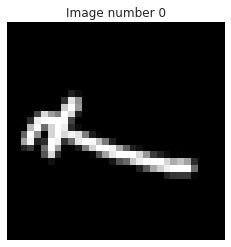

In [15]:
for i in range(0,train_data.shape[0],32):
  show_image(
    np.reshape(
        train_data.iloc[i,:].values.astype('float32'),
        (32,32),
    ), title=f'Image number {i}'
  )
  break

The database is partitioned into two sets: 
- Training set (13,440 characters to 480 images per class) => 28 classes
- Test set (3,360 characters to 120 images per class) => 28 class

In [16]:
print('Training:')
print(f'The shape of the df is: {train_data.shape}')
print(f'The meaning is: {train_data.shape[0]} letters divided in 28 categories with a (flatten) shape of {train_data.shape[1]} (32x32) pixels.')
print('='*50)
print('Test:')
print(f'The shape of the df is: {test_data.shape}')
print(f'The meaning is: {test_data.shape[0]} letters divided in 28 categories with a (flatten) shape of {train_data.shape[1]} (32x32) pixels.')

Training:
The shape of the df is: (13440, 1024)
The meaning is: 13440 letters divided in 28 categories with a (flatten) shape of 1024 (32x32) pixels.
Test:
The shape of the df is: (3360, 1024)
The meaning is: 3360 letters divided in 28 categories with a (flatten) shape of 1024 (32x32) pixels.


### Convert to array

In [17]:
# Convert images to float32
train_data = train_data.iloc[:,:].values.astype('float32')
train_label = train_label.iloc[:,:].values.astype('int32')-1

test_data = test_data.iloc[:,:].values.astype('float32')
test_label = test_label.iloc[:,:].values.astype('int32')-1

### Show: Sample of training images

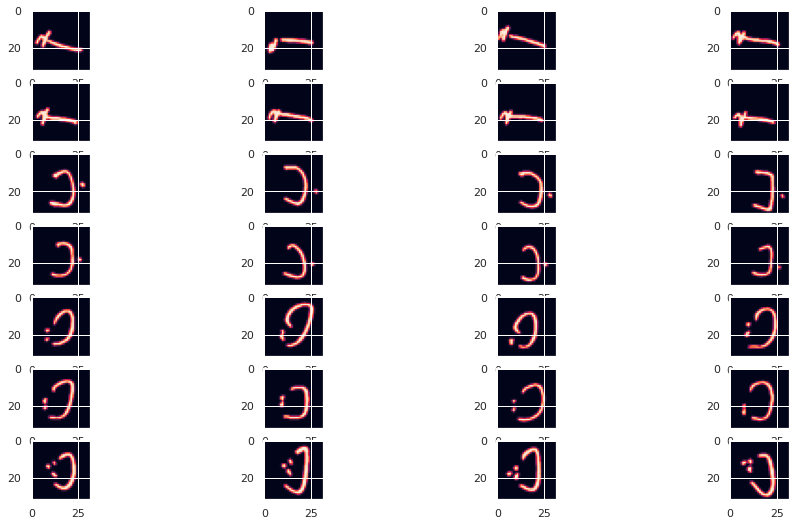

In [18]:
# Ten images 
display_image(train_data, 32, 28)

### Show: Sample of test images

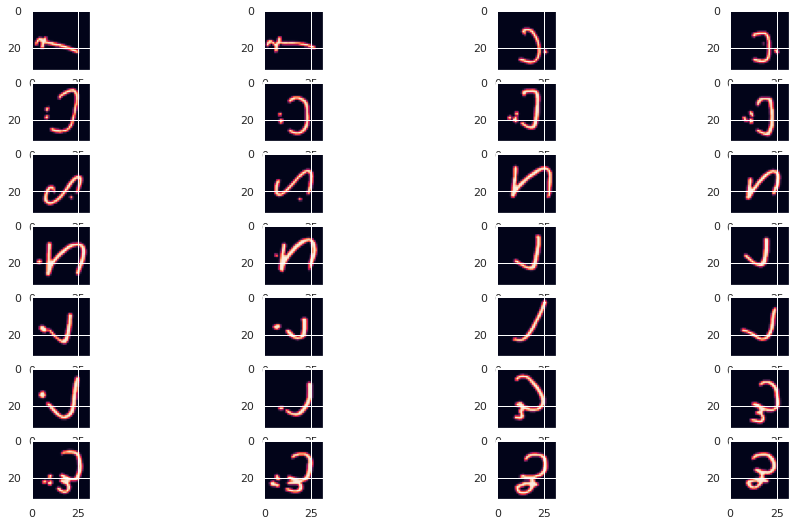

In [19]:
display_image(test_data, 32, 28)

### Shape check

In [20]:
print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)

(13440, 1024) (13440, 1)
(3360, 1024) (3360, 1)


### Normalization, zero-centering, categorical transformations

In [21]:
# Normalization [0,255] -> [0,1]
train_data = train_data/255
test_data = test_data/255

# Reshape to 2D -> #, height, width, rgb
train_data = train_data.reshape([-1, 32, 32, 1])
test_data = test_data.reshape([-1, 32, 32, 1])

# Categorical variable
train_label = tf.keras.utils.to_categorical(train_label,28)
test_label = tf.keras.utils.to_categorical(test_label,28)

print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)

(13440, 32, 32, 1) (13440, 28)
(3360, 32, 32, 1) (3360, 28)


### ImageDataGenerator: 
Generate batches of tensor image data with real-time data augmentation. This data is looped over in batches. Basically, It is used to load the images in batches.

In [22]:
validation_split = 0.2 

datagen = ImageDataGenerator(
    validation_split = validation_split,
    featurewise_center=False, 
    samplewise_center=False,  
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range = 0.1,  
    width_shift_range=0.1, 
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False)


## Model 1 
[CONV2D - CONV2D - MAXPOOL - DROPOUT] [CONV2D - CONV2D - MAXPOOL - DROPOUT] [DENSE - DENSE - DROPOUT]

### Architecture

In [23]:
with tf.device('/device:GPU:0'):
  num_classes = train_label.shape[1]
  image_size = train_data.shape[1]

  model_1 = tf.keras.Sequential()

  model_1.add(tf.keras.layers.Conv2D(32, (5, 5), padding='same', input_shape = (image_size, image_size, 1)))
  model_1.add(tf.keras.layers.Activation('relu'))
  model_1.add(tf.keras.layers.Conv2D(32, (5, 5))) # padding='same'? 
  model_1.add(tf.keras.layers.Activation('relu'))
  model_1.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model_1.add(tf.keras.layers.Dropout(0.25))

  model_1.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same'))
  model_1.add(tf.keras.layers.Activation('relu'))
  model_1.add(tf.keras.layers.Conv2D(64, (3, 3)))
  model_1.add(tf.keras.layers.Activation('relu'))
  model_1.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2))) # strides=(2,2)?
  model_1.add(tf.keras.layers.Dropout(0.25))

  model_1.add(tf.keras.layers.Flatten())
  model_1.add(tf.keras.layers.Dense(512))
  model_1.add(tf.keras.layers.Activation('relu'))
  model_1.add(tf.keras.layers.Dense(num_classes))
  model_1.add(tf.keras.layers.Activation('relu'))
  model_1.add(tf.keras.layers.Dropout(0.5))
  model_1.add(tf.keras.layers.Activation('softmax'))

  model_1.compile(
      loss = 'categorical_crossentropy',
      optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
      metrics=['accuracy']
  )

  model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        832       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 activation_1 (Activation)   (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                        

### Fit

In [24]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [25]:
name = 'FirstTry'
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard = TensorBoard(logdir, histogram_freq = 1)

Epoch 1/40
107/107 [==============================] - 14s 49ms/step - loss: 3.2987 - accuracy: 0.0652 - val_loss: 3.2140 - val_accuracy: 0.1181
Epoch 2/40
107/107 [==============================] - 5s 47ms/step - loss: 3.1976 - accuracy: 0.1306 - val_loss: 3.0633 - val_accuracy: 0.1988
Epoch 3/40
107/107 [==============================] - 5s 47ms/step - loss: 3.0732 - accuracy: 0.1772 - val_loss: 2.8841 - val_accuracy: 0.2754
Epoch 4/40
107/107 [==============================] - 5s 47ms/step - loss: 2.9609 - accuracy: 0.2131 - val_loss: 2.7624 - val_accuracy: 0.3269
Epoch 5/40
107/107 [==============================] - 5s 47ms/step - loss: 2.8612 - accuracy: 0.2488 - val_loss: 2.6083 - val_accuracy: 0.3758
Epoch 6/40
107/107 [==============================] - 5s 47ms/step - loss: 2.7864 - accuracy: 0.2772 - val_loss: 2.5108 - val_accuracy: 0.4046
Epoch 7/40
107/107 [==============================] - 5s 48ms/step - loss: 2.7293 - accuracy: 0.2901 - val_loss: 2.4878 - val_accuracy: 0.421

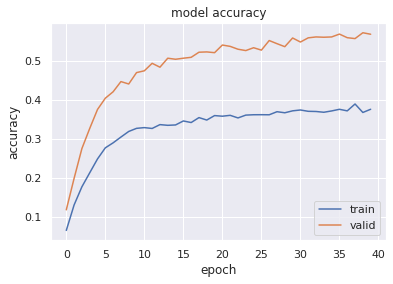

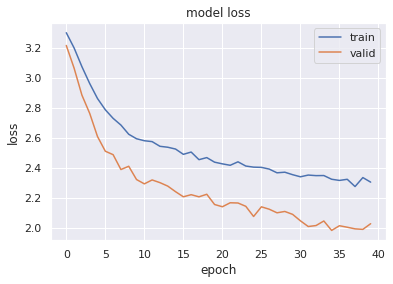

In [26]:
epochs = 40
batch_size = 100

train_generator = datagen.flow(
    train_data,train_label, batch_size = batch_size, subset = 'training', shuffle = True, seed = 123)

validation_generator = datagen.flow(
    train_data,train_label, batch_size = batch_size, subset = 'validation', shuffle = True, seed = 123)

datagen.fit(train_data)
history = model_1.fit(
    train_generator,
    steps_per_epoch = len(train_data) * (1 - validation_split) // batch_size,
    validation_data = validation_generator,
    validation_steps = len(train_data) * validation_split // batch_size,
    epochs = epochs, 
    #callbacks = [tensorboard],
)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [27]:
#%tensorboard --logdir logs

### Evaluation

Evaluate on test data
34/34 [==============================] - 0s 5ms/step - loss: 1.4622 - accuracy: 0.7051
test loss, test acc: [1.4621988534927368, 0.7050595283508301]
{'loss': 1.4621988534927368, 'accuracy': 0.7050595283508301}


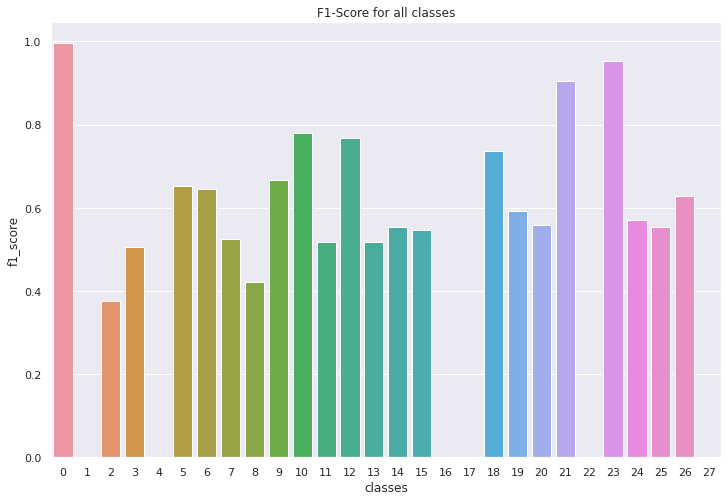

In [28]:
print("Evaluate on test data")
result = model_1.evaluate(test_data, test_label, batch_size = batch_size)
print("test loss, test acc:", result)
print(dict(zip(model_1.metrics_names, result)))

# Save model
model_1.save(path_project_dir.joinpath('models','model_1.h5'))

# Create predictions
y_pred = np.around(model_1.predict(test_data))
# Round test_data
#y_test = np.argmax(test_data, axis=1)

# Create report
metrics1 = classification_report(
      test_label,
      y_pred, 
      zero_division = True,
      #labels = test_label,
      output_dict = True
)

# Convert metrics to a df
df_metrics = (pd.DataFrame(
    metrics1, 
    columns = list(metrics1.keys())
    )
    .T
    .drop(['samples avg','weighted avg','macro avg','micro avg'])
    .reset_index()
    .rename(columns={'index':'classes','f1-score':'f1_score'})
    .drop(columns=['support'])
    
)

# Barplot of f1 score
plt.figure(figsize=(12, 8))
sns.barplot(
    x = df_metrics.classes,
    y = df_metrics.f1_score,
    data = df_metrics,
    #hue="model"
)

plt.title('F1-Score for all classes')
plt.show()

## Model 2 

### Architecture
[CONV2D - MAXPOOL] [CONV2D - MAXPOOL] [DENSE - DROPOUT - DENSE]

In [29]:
num_classes = train_label.shape[1]
image_size = train_data.shape[1]

model_2 = tf.keras.Sequential()
model_2.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape = (image_size, image_size, 1)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Conv2D(32, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Conv2D(64, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# this converts our 3D feature maps to 1D feature vectors
model_2.add(Flatten())  
model_2.add(Dense(64))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(num_classes))
model_2.add(Activation('softmax'))

model_2.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        320       
                                                                 
 activation_7 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 activation_8 (Activation)   (None, 14, 14, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                  

### Fit

Epoch 1/150
107/107 [==============================] - 6s 47ms/step - loss: 3.3251 - accuracy: 0.0462 - val_loss: 3.3126 - val_accuracy: 0.0777
Epoch 2/150
107/107 [==============================] - 5s 45ms/step - loss: 3.2870 - accuracy: 0.0692 - val_loss: 3.2340 - val_accuracy: 0.1073
Epoch 3/150
107/107 [==============================] - 5s 46ms/step - loss: 3.1796 - accuracy: 0.0954 - val_loss: 3.0670 - val_accuracy: 0.1285
Epoch 4/150
107/107 [==============================] - 5s 47ms/step - loss: 3.0188 - accuracy: 0.1197 - val_loss: 2.8978 - val_accuracy: 0.1665
Epoch 5/150
107/107 [==============================] - 5s 45ms/step - loss: 2.8981 - accuracy: 0.1544 - val_loss: 2.7737 - val_accuracy: 0.1962
Epoch 6/150
107/107 [==============================] - 5s 45ms/step - loss: 2.7586 - accuracy: 0.1847 - val_loss: 2.6431 - val_accuracy: 0.2338
Epoch 7/150
107/107 [==============================] - 5s 45ms/step - loss: 2.6665 - accuracy: 0.2056 - val_loss: 2.5395 - val_accuracy:

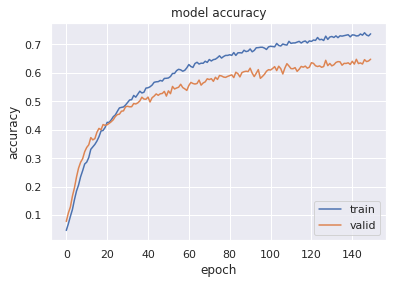

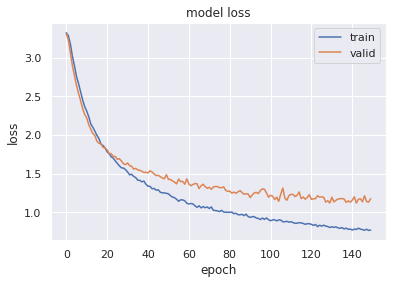

In [30]:
with tf.device('/device:GPU:0'):
  epochs = 150
  batch_size = 100

  train_generator = datagen.flow(
      train_data,train_label, batch_size = batch_size, subset = 'training', shuffle = True, seed = 123)

  validation_generator = datagen.flow(
      train_data,train_label, batch_size = batch_size, subset = 'validation', shuffle = True, seed = 123)

  datagen.fit(train_data)
  history = model_2.fit(
      train_generator,
      steps_per_epoch = len(train_data) * (1 - validation_split) // batch_size,
      validation_data = validation_generator,
      validation_steps = len(train_data) * validation_split // batch_size,
      epochs = epochs, 
      #callbacks = [tensorboard],
  )

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='lower right')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper right')
  plt.show()

### Evaluation

Evaluate on test data
34/34 [==============================] - 0s 4ms/step - loss: 0.4883 - accuracy: 0.8420
test loss, test acc: [0.48830297589302063, 0.8419643044471741]
{'loss': 0.48830297589302063, 'accuracy': 0.8419643044471741}


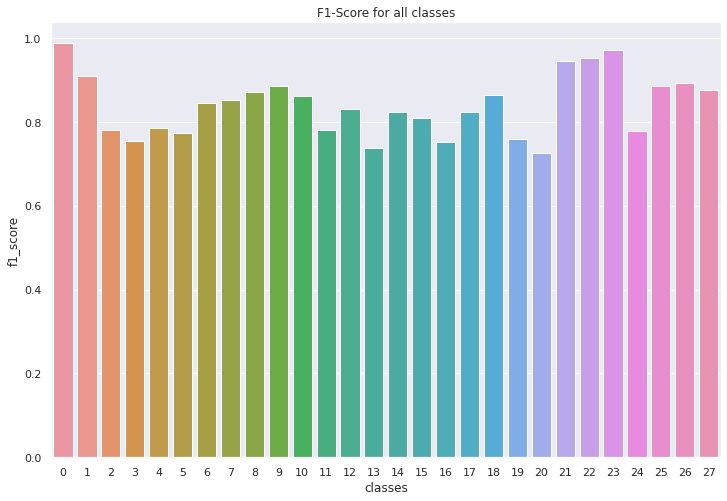

In [31]:
print("Evaluate on test data")
result = model_2.evaluate(test_data, test_label, batch_size = batch_size)
print("test loss, test acc:", result)
print(dict(zip(model_2.metrics_names, result)))

# Save model
model_2.save(path_project_dir.joinpath('models','model_2.h5'))

# Create predictions
y_pred = np.around(model_2.predict(test_data))
# Round test_data
#y_test = np.argmax(test_data, axis=1)

# Create report
metrics2 = classification_report(
      test_label,
      y_pred, 
      zero_division = True,
      #labels = test_label,
      output_dict = True
)

# Convert metrics to a df
df_metrics = (pd.DataFrame(
    metrics2, 
    columns = list(metrics2.keys())
    )
    .T
    .drop(['samples avg','weighted avg','macro avg','micro avg'])
    .reset_index()
    .rename(columns={'index':'classes','f1-score':'f1_score'})
    .drop(columns=['support'])
    
)

# Barplot of f1 score
plt.figure(figsize=(12, 8))
sns.barplot(
    x = df_metrics.classes,
    y = df_metrics.f1_score,
    data = df_metrics,
    #hue="model"
)

plt.title('F1-Score for all classes')
plt.show()

## Model 3 Modifications increasing `learning_rate`. 
The learning rate of our model was not declining fast enough, therefore we have adapted our learning rate, we decrease it by a factor of 10. 

### Architecture

In [32]:
num_classes = train_label.shape[1]
image_size = train_data.shape[1]

model_3 = tf.keras.Sequential()
model_3.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape = (image_size, image_size, 1)))
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

model_3.add(Conv2D(32, (3, 3)))
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

model_3.add(Conv2D(64, (3, 3)))
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

# this converts our 3D feature maps to 1D feature vectors
model_3.add(Flatten())  
model_3.add(Dense(64))
model_3.add(Activation('relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(num_classes))
model_3.add(Activation('softmax'))

model_3.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        320       
                                                                 
 activation_12 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 activation_13 (Activation)  (None, 14, 14, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                  

### Fit

Epoch 1/150
107/107 [==============================] - 6s 50ms/step - loss: 3.0905 - accuracy: 0.0990 - val_loss: 2.4835 - val_accuracy: 0.2546
Epoch 2/150
107/107 [==============================] - 5s 47ms/step - loss: 2.2695 - accuracy: 0.2812 - val_loss: 1.8738 - val_accuracy: 0.4023
Epoch 3/150
107/107 [==============================] - 5s 50ms/step - loss: 1.7729 - accuracy: 0.4189 - val_loss: 1.6518 - val_accuracy: 0.4696
Epoch 4/150
107/107 [==============================] - 5s 47ms/step - loss: 1.4697 - accuracy: 0.5038 - val_loss: 1.4962 - val_accuracy: 0.5219
Epoch 5/150
107/107 [==============================] - 5s 47ms/step - loss: 1.3169 - accuracy: 0.5468 - val_loss: 1.3518 - val_accuracy: 0.5588
Epoch 6/150
107/107 [==============================] - 5s 47ms/step - loss: 1.1830 - accuracy: 0.5920 - val_loss: 1.3180 - val_accuracy: 0.5808
Epoch 7/150
107/107 [==============================] - 5s 47ms/step - loss: 1.1071 - accuracy: 0.6192 - val_loss: 1.2917 - val_accuracy:

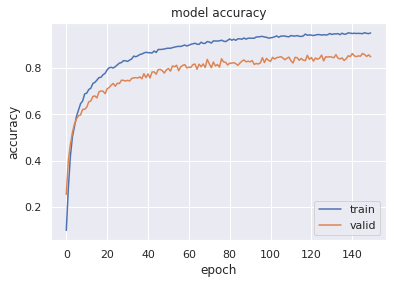

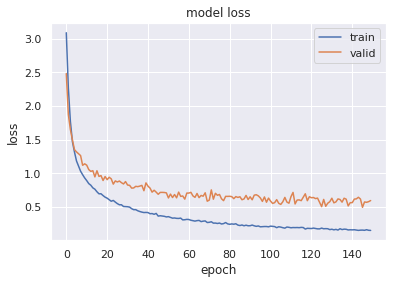

In [33]:
with tf.device('/device:GPU:0'):
  epochs = 150
  batch_size = 100

  train_generator = datagen.flow(
      train_data,train_label, batch_size = batch_size, subset = 'training', shuffle = True, seed = 123)

  validation_generator = datagen.flow(
      train_data,train_label, batch_size = batch_size, subset = 'validation', shuffle = True, seed = 123)

  datagen.fit(train_data)
  history = model_3.fit(
      train_generator,
      steps_per_epoch = len(train_data) * (1 - validation_split) // batch_size,
      validation_data = validation_generator,
      validation_steps = len(train_data) * validation_split // batch_size,
      epochs = epochs, 
      #callbacks = [tensorboard],
  )

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='lower right')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper right')
  plt.show()

### Evaluation

Evaluate on test data
34/34 [==============================] - 0s 4ms/step - loss: 0.1812 - accuracy: 0.9583
test loss, test acc: [0.1811901479959488, 0.9583333134651184]
{'loss': 0.1811901479959488, 'accuracy': 0.9583333134651184}


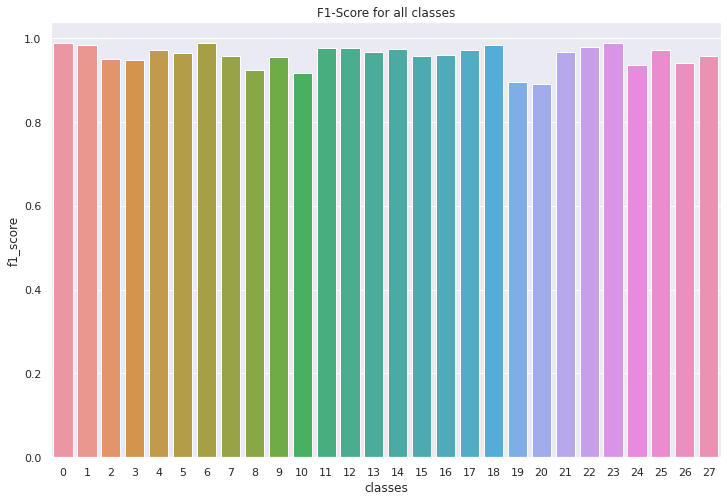

In [34]:
print("Evaluate on test data")
result = model_3.evaluate(test_data, test_label, batch_size = batch_size)
print("test loss, test acc:", result)
print(dict(zip(model_3.metrics_names, result)))

# Save model
model_3.save(path_project_dir.joinpath('models','model_3.h5'))

# Create predictions
y_pred = np.around(model_3.predict(test_data))
# Round test_data
#y_test = np.argmax(test_data, axis=1)

# Create report
metrics3 = classification_report(
      test_label,
      y_pred, 
      zero_division = True,
      #labels = test_label,
      output_dict = True
)

# Convert metrics to a df
df_metrics = (pd.DataFrame(
    metrics3, 
    columns = list(metrics3.keys())
    )
    .T
    .drop(['samples avg','weighted avg','macro avg','micro avg'])
    .reset_index()
    .rename(columns={'index':'classes','f1-score':'f1_score'})
    .drop(columns=['support'])
    
)

# Barplot of f1 score
plt.figure(figsize=(12, 8))
sns.barplot(
    x = df_metrics.classes,
    y = df_metrics.f1_score,
    data = df_metrics,
    #hue="model"
)

plt.title('F1-Score for all classes')
plt.show()

## Model 4 Modification of CONV2D

### Architecture

In [35]:
num_classes = train_label.shape[1]
image_size = train_data.shape[1]

model_4 = tf.keras.Sequential()
model_4.add(Conv2D(64, (3, 3), padding='same', input_shape = (image_size, image_size, 1)))
model_4.add(Activation('relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))

model_4.add(Conv2D(32, (3, 3)))
model_4.add(Activation('relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))

model_4.add(Conv2D(32, (3, 3)))
model_4.add(Activation('relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))

# this converts our 3D feature maps to 1D feature vectors
model_4.add(Flatten())  
model_4.add(Dense(64))
model_4.add(Activation('relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(num_classes))
model_4.add(Activation('softmax'))

model_4.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 32, 32, 64)        640       
                                                                 
 activation_17 (Activation)  (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 32)        18464     
                                                                 
 activation_18 (Activation)  (None, 14, 14, 32)        0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                  

### Fit

Epoch 1/150
107/107 [==============================] - 6s 48ms/step - loss: 3.1533 - accuracy: 0.0920 - val_loss: 2.7104 - val_accuracy: 0.2019
Epoch 2/150
107/107 [==============================] - 5s 47ms/step - loss: 2.3567 - accuracy: 0.2658 - val_loss: 1.9303 - val_accuracy: 0.3842
Epoch 3/150
107/107 [==============================] - 5s 46ms/step - loss: 1.8294 - accuracy: 0.3991 - val_loss: 1.7449 - val_accuracy: 0.4431
Epoch 4/150
107/107 [==============================] - 5s 46ms/step - loss: 1.5253 - accuracy: 0.4806 - val_loss: 1.5840 - val_accuracy: 0.4927
Epoch 5/150
107/107 [==============================] - 5s 47ms/step - loss: 1.3463 - accuracy: 0.5280 - val_loss: 1.4757 - val_accuracy: 0.5335
Epoch 6/150
107/107 [==============================] - 5s 46ms/step - loss: 1.2251 - accuracy: 0.5728 - val_loss: 1.3441 - val_accuracy: 0.5800
Epoch 7/150
107/107 [==============================] - 5s 47ms/step - loss: 1.1344 - accuracy: 0.6021 - val_loss: 1.3503 - val_accuracy:

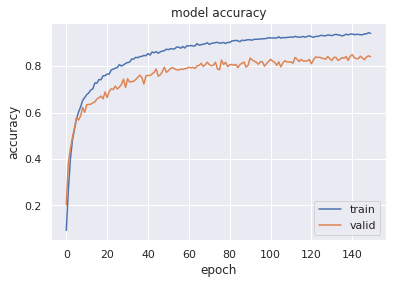

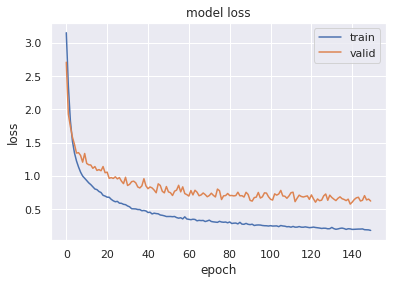

In [36]:
device_name = tf.test.gpu_device_name()

with tf.device('/device:GPU:0'):
  epochs = 150
  batch_size = 100

  train_generator = datagen.flow(
      train_data,train_label, batch_size = batch_size, subset = 'training', shuffle = True, seed = 123)

  validation_generator = datagen.flow(
      train_data,train_label, batch_size = batch_size, subset = 'validation', shuffle = True, seed = 123)

  datagen.fit(train_data)
  history = model_4.fit(
      train_generator,
      steps_per_epoch = len(train_data) * (1 - validation_split) // batch_size,
      validation_data = validation_generator,
      validation_steps = len(train_data) * validation_split // batch_size,
      epochs = epochs, 
      #callbacks = [tensorboard],
  )

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='lower right')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper right')
  plt.show()

### Evaluation

Evaluate on test data
34/34 [==============================] - 0s 5ms/step - loss: 0.2065 - accuracy: 0.9503
test loss, test acc: [0.20652934908866882, 0.9502975940704346]
{'loss': 0.20652934908866882, 'accuracy': 0.9502975940704346}


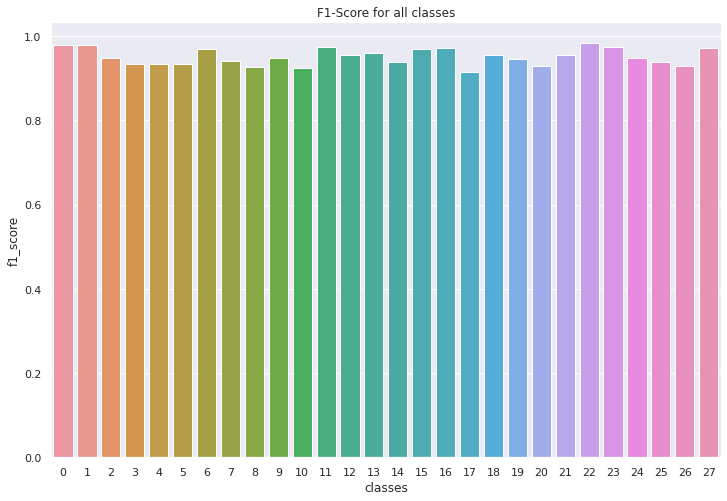

In [37]:
print("Evaluate on test data")
result = model_4.evaluate(test_data, test_label, batch_size = batch_size)
print("test loss, test acc:", result)
print(dict(zip(model_4.metrics_names, result)))

# Save model
#model_4.save(path_project_dir.joinpath('models','model_4.h5'))

# Create predictions
y_pred = np.around(model_4.predict(test_data))
# Round test_data
#y_test = np.argmax(test_data, axis=1)

# Create report
metrics4 = classification_report(
      test_label,
      y_pred, 
      zero_division = True,
      #labels = test_label,
      output_dict = True
)

# Convert metrics to a df
df_metrics = (pd.DataFrame(
    metrics4, 
    columns = list(metrics4.keys())
    )
    .T
    .drop(['samples avg','weighted avg','macro avg','micro avg'])
    .reset_index()
    .rename(columns={'index':'classes','f1-score':'f1_score'})
    .drop(columns=['support'])
    
)

# Barplot of f1 score
plt.figure(figsize=(12, 8))
sns.barplot(
    x = df_metrics.classes,
    y = df_metrics.f1_score,
    data = df_metrics,
    #hue="model"
)

plt.title('F1-Score for all classes')
plt.show()

## Neural Transfer

In [38]:
%tensorflow_version 1.x
tf.compat.v1.enable_eager_execution()

TensorFlow is already loaded. Please restart the runtime to change versions.


### Get label values

In [140]:
# Path to images
path_to_images = path_project_dir.joinpath('data','images')
# arabic labels 
arabic_labels = {0: 'Alif',1: 'Ayeen',2: 'Baa',3: 'Daal',4: 'Faa',5: 'Ghaeen',6: 'Haa',7: 'Jeem',8: 'Kaaf',
                 9: 'Khaa',10: 'Laam',11: 'Meem',12: 'Nuun',13: 'Qouf',14: 'Raa',15: 'Saa',16: 'Seen',17: 'Sheen',
                 18: "Su'ad",19: 'Taa',20: 'Tuaa',21: 'Waoo',22: 'Yaa',23: 'Zaal',24: 'Zazza',25: "Zu'ad",26: 'Zua',
                 27: 'huu'}
# approximation - alphabet to arabic
alphabet_to_arabic = {'a': 'Alif','b': 'Baa','d':'Daal','f': 'Faa','r': 'Ghaeen','h': 'Haa','j': 'Jeem','k': 'Kaaf','l': 'Laam',
                      'm': 'Meem','n': 'Nuun','q': 'Qouf','r': 'Raa','s': 'Saa','t': 'Taa','u': 'Waoo','i': 'Yaa','z': 'Zaal'}
# approximation - arabib to alphabet
arabic_to_alphabet = {v:k for k,v in alphabet_to_arabic.items()}

In [217]:
# Load train/test data
test_data = pd.read_csv(path_to_data.joinpath('csvTestImages 3360x1024.csv'),header = None)
# Load train/test labels
test_label = pd.read_csv(path_to_data.joinpath('csvTestLabel 3360x1.csv'),header = None)
# Create new df
df_test = test_label.rename(columns={0:'label'})
# Convert images to float32 & Reshape to 2D -> #, height, width, rgb
test_data = test_data.iloc[:,:].values.astype('float32').reshape([-1, 32, 32, 1])

print(test_data.shape) 
print(test_label.shape)

(3360, 32, 32, 1)
(3360, 1)


In [219]:
def get_img(img_num):
  n_samples = test_data.shape[0]
  return test_data.reshape(n_samples, 32, 32)[img_num]

df_test = (df_test
            .assign(label = lambda x: x.label -1)
            .assign(name = lambda x: x.label.apply(arabic_labels.get))
            .assign(equivalent = lambda x: x.name.apply(arabic_to_alphabet.get))
            .assign(img_array = lambda x: x.label.apply(get_img)))

df_test.head()

,label,name,equivalent,img_array
0,0,Alif,a,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,0,Alif,a,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,1,Ayeen,None,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,1,Ayeen,None,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,2,Baa,b,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


Image array input "Alif" equivalent to "a"


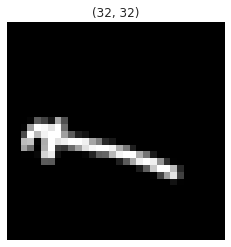

0

In [222]:
n = 0 #
# Create a sample img
test_sample = df_test[df_test.label == n]
print(f'Image array input "{test_sample.name.values[0]}" equivalent to "{test_sample.equivalent.values[0]}"')
test_img = test_sample.img_array.values[0]
# Show this image
show_image(test_img,title = test_img.shape)
# Show prediction
to_predict = test_img.reshape(-1,32,32,1)
# Get prediction
prediction = np.argmax(model_4.predict([to_predict]))
prediction

In [231]:
prediction_value = arabic_to_alphabet[arabic_labels[prediction]]

content_path = {
  item.split('/')[-2][0]:item for item in glob(str(path_project_dir.joinpath('data','images','content'))+'*/*/*')
}
#content_path = glob(str(path_project_dir.joinpath('data','images','content'))+'*/*/*')
style_path ={ 
  item.split('/')[-2]:item for item in glob(str(path_project_dir.joinpath('data','images','style'))+'*/*/*')
}

content_path = content_path[prediction_value]
style_path = style_path[prediction_value]
content_path
style_path

'/content/drive/MyDrive/DeepLearningInVisionHSLU/DLV03_Project/data/images/style/a/a.jpeg'

In [232]:
def load_img(path_to_img):
  max_dim = 512
  img = Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  
  img = kp_image.img_to_array(img)
  
  # We need to broadcast the image array such that it has a batch dimension 
  img = np.expand_dims(img, axis=0)
  return img

def imshow(img, title=None):
  # Remove the batch dimension
  out = np.squeeze(img, axis=0)
  # Normalize for display 
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)

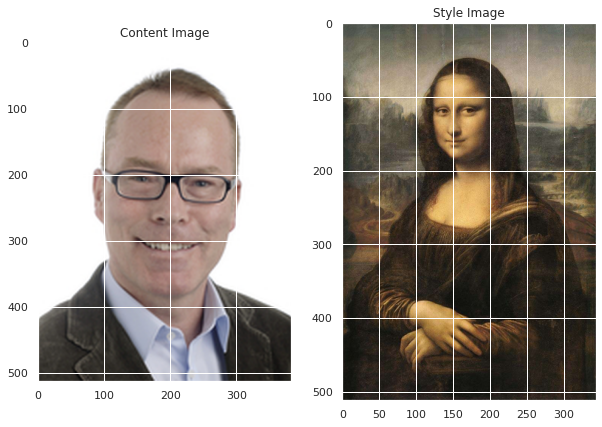

In [233]:
plt.figure(figsize=(10,10))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

In [234]:
def load_and_process_img(path_to_img):
  img = load_img(path_to_img)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

In [235]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [236]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [237]:
def get_model():
  # Load our model. We load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  # Get output layers corresponding to style and content layers 
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs
  # Build model 
  return models.Model(vgg.input, model_outputs)

In [238]:
def get_content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))

In [239]:
def gram_matrix(input_tensor):
  # We make the image channels first 
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
  """Expects two images of dimension h, w, c"""
  # height, width, num filters of each layer
  # We scale the loss at a given layer by the size of the feature map and the number of filters
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)
  
  return tf.reduce_mean(tf.square(gram_style - gram_target))# / (4. * (channels ** 2) * (width * height) ** 2)

In [240]:
def get_feature_representations(model, content_path, style_path):
  # Load our images in 
  content_image = load_and_process_img(content_path)
  style_image = load_and_process_img(style_path)
  
  # batch compute content and style features
  style_outputs = model(style_image)
  content_outputs = model(content_image)
  
  # Get the style and content feature representations from our model  
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

In [241]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  style_weight, content_weight = loss_weights
  
  # Feed our init image through our model. This will give us the content and 
  # style representations at our desired layers. Since we're using eager
  # our model is callable just like any other function!
  model_outputs = model(init_image)
  
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  
  style_score = 0
  content_score = 0

  # Accumulate style losses from all layers
  # Here, we equally weight each contribution of each loss layer
  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
  # Accumulate content losses from all layers 
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
  style_score *= style_weight
  content_score *= content_weight

  # Get total loss
  loss = style_score + content_score 
  return loss, style_score, content_score

In [242]:
def compute_grads(cfg):
  with tf.GradientTape() as tape: 
    all_loss = compute_loss(**cfg)
  # Compute gradients wrt input image
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

In [243]:
import IPython.display

def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3, 
                       style_weight=1e-2): 
  # We don't need to (or want to) train any layers of our model, so we set their
  # trainable to false. 
  model = get_model() 
  for layer in model.layers:
    layer.trainable = False
  
  # Get the style and content feature representations (from our specified intermediate layers) 
  style_features, content_features = get_feature_representations(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
  # Set initial image
  init_image = load_and_process_img(content_path)
  init_image = tf.Variable(init_image, dtype=tf.float32)
  # Create our optimizer
  opt = tf.compat.v1.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)
  

  # For displaying intermediate images 
  iter_count = 1
  
  # Store our best result
  best_loss, best_img = float('inf'), None
  
  # Create a nice config 
  loss_weights = (style_weight, content_weight)
  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
    
  # For displaying
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  start_time = time.time()
  global_start = time.time()
  
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  
  imgs = []
  for i in range(num_iterations):
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time() 
    
    if loss < best_loss:
      # Update best loss and best image from total loss. 
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

    if i % display_interval== 0:
      start_time = time.time()
      
      # Use the .numpy() method to get the concrete numpy array
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])
      
  return best_img, best_loss 

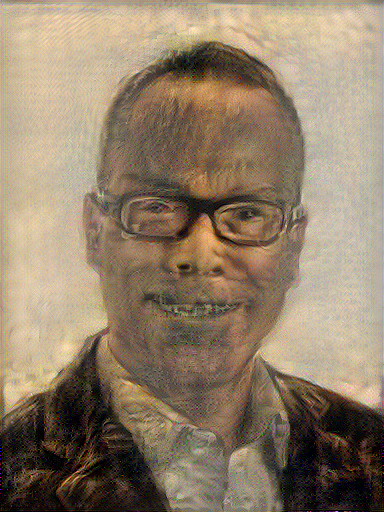

Iteration: 900
Total loss: 2.7767e+05, style loss: 1.0548e+05, content loss: 1.7220e+05, time: 0.0563s
Total time: 82.9394s


In [ ]:
best, best_loss = run_style_transfer(content_path, 
                                     style_path, num_iterations=1000)

In [ ]:
def show_results(best_img, content_path, style_path, show_large_final=True):
  plt.figure(figsize=(10, 5))
  content = load_img(content_path) 
  style = load_img(style_path)

  plt.subplot(1, 2, 1)
  imshow(content, 'Content Image')

  plt.subplot(1, 2, 2)
  imshow(style, 'Style Image')

  if show_large_final: 
    plt.figure(figsize=(10, 10))

    plt.imshow(best_img)
    plt.title('Output Image')
    plt.show()

In [ ]:
show_results(best, content_path, style_path)